# Xopt CNSGA algorithm

In [1]:
from xopt.generators.ga.cnsga import CNSGAGenerator

from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

from xopt import Xopt, Evaluator

import pandas as pd

In [2]:
# Useful for debugging
#%load_ext autoreload
#%autoreload 2

In [3]:
ev = Evaluator(function=evaluate_TNK)
ev.function_kwargs = {'raise_probability':0.1} # optional random crashing, to mimic real-world use. 

In [4]:
X = Xopt(
    generator=CNSGAGenerator(vocs=tnk_vocs),
    evaluator=ev,
    vocs=tnk_vocs,
)
X.strict = False

Run 100 generations

In [5]:
%%time
for _ in range(64 * 20):
    X.step()

CPU times: user 5.54 s, sys: 21 ms, total: 5.56 s
Wall time: 5.56 s


# Plot 

In [6]:
import matplotlib.pyplot as plt

In [7]:
def plot_population(X):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    fdata = tnk_vocs.feasibility_data(X.data)
    
    k1 = "x1"
    k2 = "x2"
    
    X.data.plot.scatter(k1, k2, marker=".", alpha=0.1, color="black", ax=ax)
    X.data[fdata["feasible"]].plot.scatter(
        k1, k2, marker="x", alpha=0.3, color="orange", ax=ax
    )
    X.generator.population.plot.scatter(k1, k2, marker="o", color="red", alpha=1, ax=ax)
    ax.set_xlabel(k1)
    ax.set_ylabel(k2)
    ax.set_xlim(0, 1.5)
    ax.set_ylim(0, 1.5)
    ax.set_title("TNK with Xopt's CNSGA")

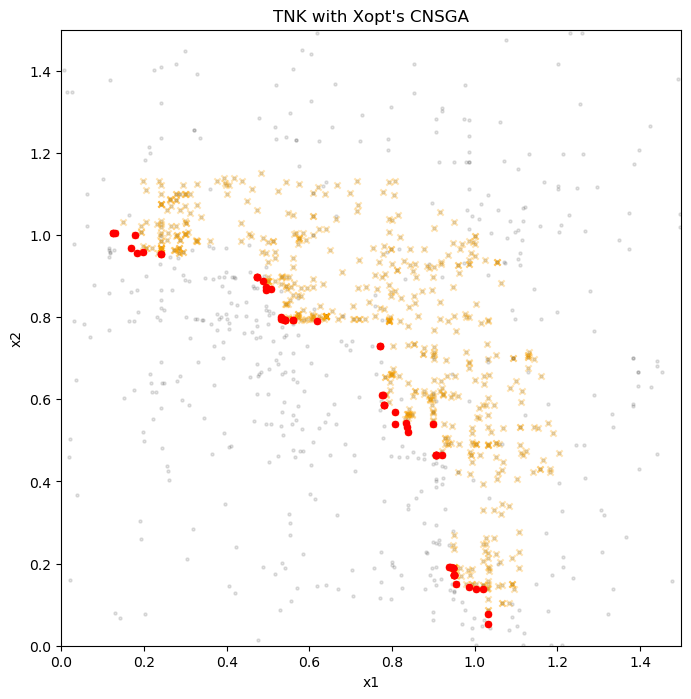

In [8]:
plot_population(X)

Write the current population

In [9]:
X.generator.write_population('test.csv')

# YAML method

In [10]:
from xopt import Xopt

In [11]:
YAML = """
max_evaluations: 6400
strict: False
generator:
    name: cnsga
    population_size: 64
    population_file: test.csv
    output_path: .

evaluator:
    function: xopt.resources.test_functions.tnk.evaluate_TNK
    function_kwargs:
      raise_probability: 0.1

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE, y2: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""

X = Xopt(YAML)
X


            Xopt
________________________________
Version: 0+untagged.1.g4e79982
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0.1
    random_sleep: 0
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.9
  mutation_probability: 1.0
  name: cnsga
  output_path: .
  population: null
  population_file: test.csv
  population_size: 64
  supports_multi_objective: true
max_evaluations: 6400
serialize_inline: false
serialize_torch: false
strict: false
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINIMIZE
    y2: MINIMIZE
  observables: []
  variables:
    x1:
    - 0.0
    - 3.14159
    x2:
    - 0.0
    - 3.14159


This will have loaded children from the population file. These will need to be re-evaluated.

In [12]:
len(X.generator._children)

64

In [13]:
%%time
X.run()

CPU times: user 27.7 s, sys: 56.6 ms, total: 27.8 s
Wall time: 27.8 s


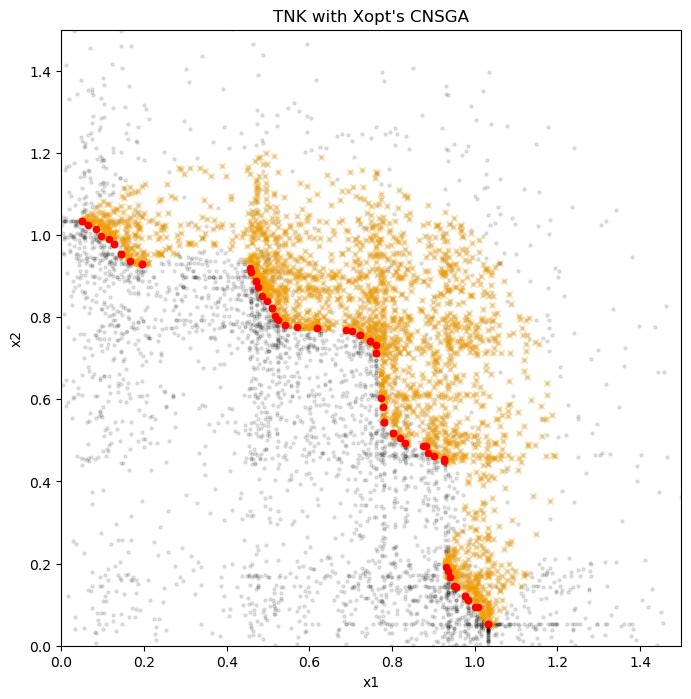

In [14]:
plot_population(X)

In [15]:
len(X.data)

6400

Setting `output_path` will write .csv files for each population, as well as the offspring considered in each generation

In [16]:
from glob import glob
pop_files = sorted(glob("cnsga_population*"))
pop_files[:10]

['cnsga_population_2023-10-27T19:50:52.519406+00:00.csv',
 'cnsga_population_2023-10-27T19:50:52.796457+00:00.csv',
 'cnsga_population_2023-10-27T19:50:53.070866+00:00.csv',
 'cnsga_population_2023-10-27T19:50:53.346656+00:00.csv',
 'cnsga_population_2023-10-27T19:50:53.625261+00:00.csv',
 'cnsga_population_2023-10-27T19:50:53.903258+00:00.csv',
 'cnsga_population_2023-10-27T19:50:54.180198+00:00.csv',
 'cnsga_population_2023-10-27T19:50:54.452464+00:00.csv',
 'cnsga_population_2023-10-27T19:50:54.723697+00:00.csv',
 'cnsga_population_2023-10-27T19:50:54.997672+00:00.csv']

In [17]:
offspring_files = sorted(glob("cnsga_offspring*"))
offspring_files[0:10]

['cnsga_offspring_2023-10-27T19:50:52.517766+00:00.csv',
 'cnsga_offspring_2023-10-27T19:50:52.794879+00:00.csv',
 'cnsga_offspring_2023-10-27T19:50:53.069292+00:00.csv',
 'cnsga_offspring_2023-10-27T19:50:53.345117+00:00.csv',
 'cnsga_offspring_2023-10-27T19:50:53.623622+00:00.csv',
 'cnsga_offspring_2023-10-27T19:50:53.901678+00:00.csv',
 'cnsga_offspring_2023-10-27T19:50:54.178554+00:00.csv',
 'cnsga_offspring_2023-10-27T19:50:54.450904+00:00.csv',
 'cnsga_offspring_2023-10-27T19:50:54.722149+00:00.csv',
 'cnsga_offspring_2023-10-27T19:50:54.996123+00:00.csv']

<Axes: xlabel='x1', ylabel='x2'>

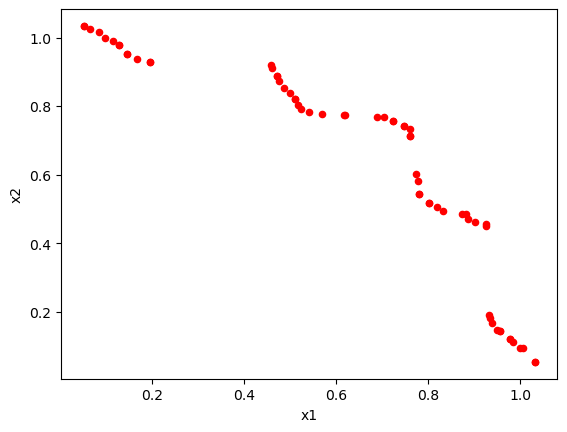

In [18]:
from xopt.utils import read_xopt_csv
pop_df = read_xopt_csv(pop_files[-1])
pop_df.plot.scatter("x1", "x2", marker="o", color="red", alpha=1)

Similarly, offsrping files can be loaded. This will load the last few:

<Axes: xlabel='x1', ylabel='x2'>

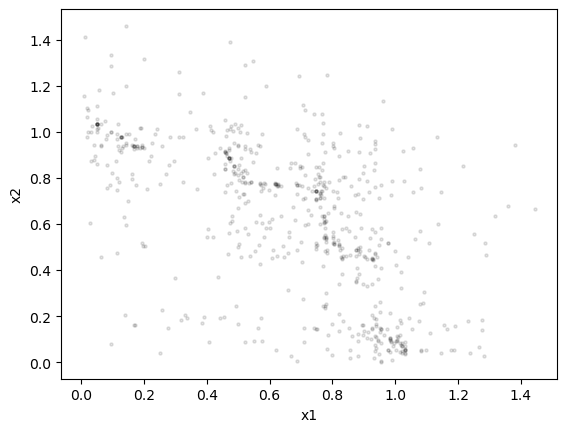

In [19]:
offspring_df = read_xopt_csv(*offspring_files[-10:])
offspring_df.plot.scatter("x1", "x2", marker=".", color="black", alpha=.1)

Occationally there are duplicates in offspring

In [20]:
all_offspring = read_xopt_csv(*offspring_files) 
len(all_offspring), len(all_offspring.drop_duplicates())

(6400, 6321)

In [21]:
# Cleanup
!rm cnsga_population*
!rm cnsga_offspring*
!rm test.csv

# Examine generator

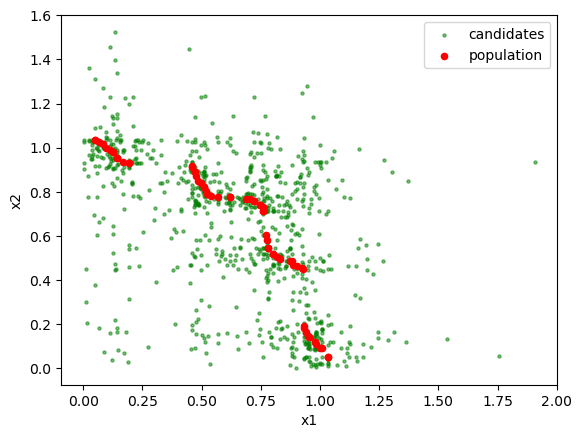

In [22]:
df = pd.DataFrame(X.generator.generate(1000))

fig, ax = plt.subplots()
df.plot.scatter("x1", "x2", marker=".", color="green", alpha=0.5, ax=ax, label='candidates')
pop_df.plot.scatter("x1", "x2", marker="o", color="red", alpha=1, ax=ax, label='population')
plt.legend()

# Vectorized evaluation

Some functions also allow vectorized inputs. This can often be very fast.

However, vectorized evaluation has some restrictions. For example, the output dict cannot append additional arrays with odd lengths.

In [23]:
# Notice that this returns `some_array`
evaluate_TNK({'x1':1, 'x2':1})

{'y1': 1, 'y2': 1, 'c1': 0.9, 'c2': 0.5}

In [24]:
# Here we make a version that does not have this
def evaluate_TNK2(*args, **kwargs):
    outputs = evaluate_TNK(*args, **kwargs)
    outputs.pop('some_array')
    return outputs

In [25]:
from xopt import Xopt

YAML = """
max_evaluations: 6400
strict: False
generator:
    name: cnsga
    population_size: 64

evaluator:
    function: __main__.evaluate_TNK2
    function_kwargs:
      raise_probability: 0.1
    vectorized: True
    max_workers: 100 

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE, y2: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""


X2 = Xopt.from_yaml(YAML)
X2.evaluator.function = evaluate_TNK2

X2.run()

len(X2.data)

6400

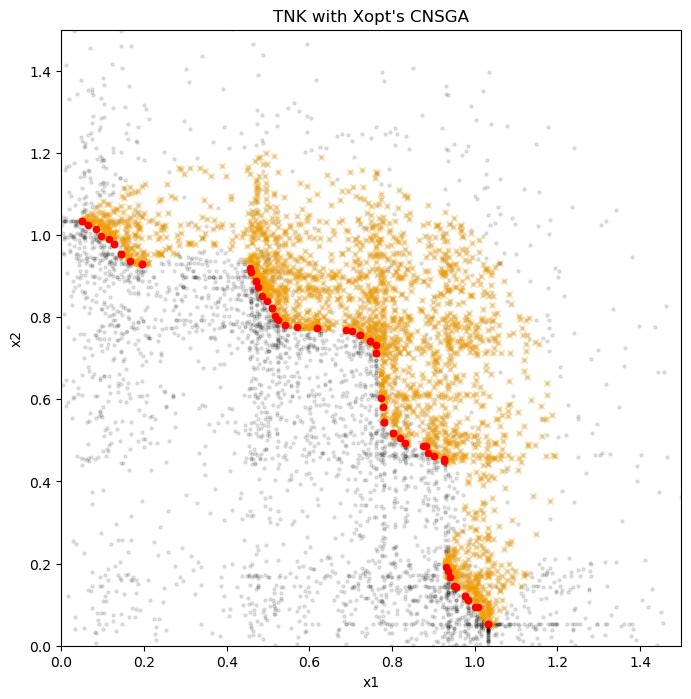

In [26]:
plot_population(X)